In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import rc
from time import time
import warnings
warnings.filterwarnings('ignore')

rc('font', size=16)

## Load data

In [3]:
data_df = pd.read_pickle('../processed_data/best36_beijing_pm25.pickle')
station_df = pd.read_csv('../raw_data/Air20Quality20Data/Beijing/Station.txt').set_index('station_id')
station_df = station_df.rename(columns={'longtitude':'longitude'}) # Small correction
data_df.head(2)

,station_id,PM25_AQI_value,PM10_AQI_value,NO2_AQI_value,temperature,pressure,humidity,wind,weather,station_name,longitude,latitude
time,,,,,,,,,,,,
2013-11-08 14:26:00,1004,151.0,93.0,41.0,13.0,1020.0,33.0,2.0,3.0,fengtaiyungang,116.171150,39.815129
2013-11-08 14:26:00,1018,165.0,90.0,42.0,13.0,1020.0,33.0,2.0,3.0,yizhuangkaifaqu,116.506319,39.794491


### Missing meteorological data per station

In [3]:
print('Station ID', 'Number of time-stamps for which Weather info is available', sep=' '*5)
for station in data_df.station_id.unique():
    print(station, data_df[data_df.station_id==station]['temperature'].dropna().shape[0], sep=' '*12)

Station ID     Number of time-stamps for which Weather info is available
1004            277
1018            277
1025            275
1022            277
1024            276
1005            277
1016            277
1019            277
1011            277
1026            271
1031            277
1028            258
1027            259
1010            277
1036            223
1034            231
1012            277
1021            277
1001            277
1035            228
1023            277
1014            277
1033            240
1007            277
1015            277
1003            277
1030            248
1009            277
1013            277
1032            263
1020            277
1006            277
1029            255
1008            277
1002            277
1017            277


### Visualize interpolations

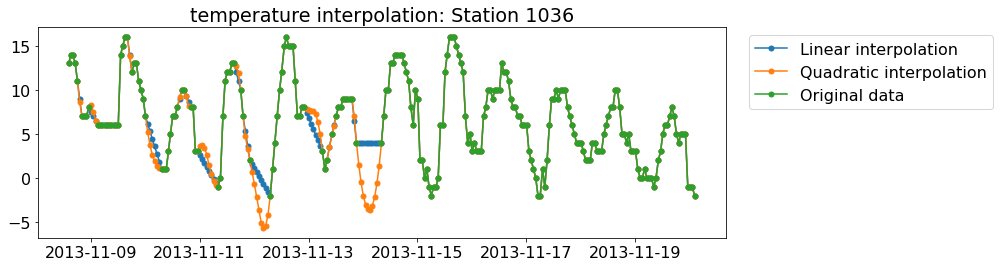

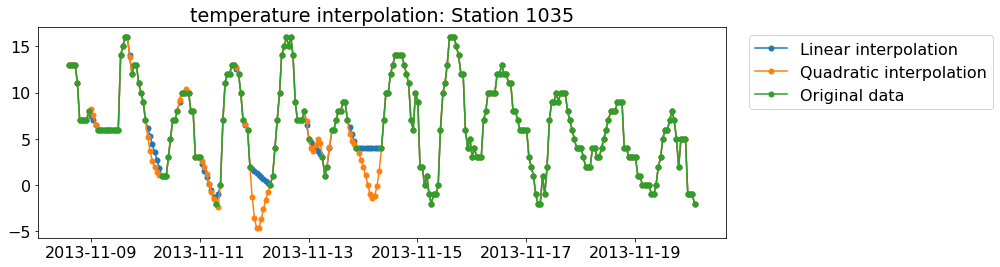

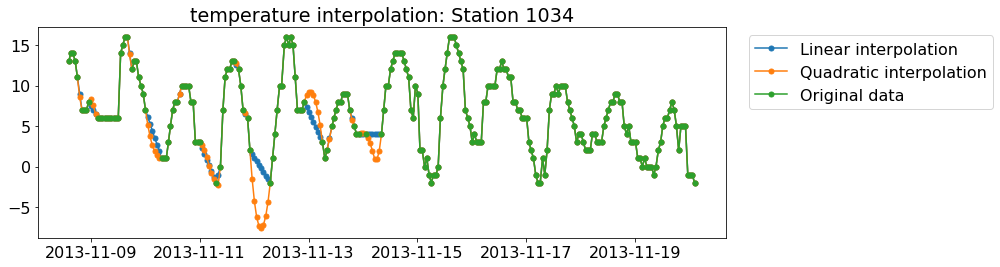

In [4]:
### Visualize interpolated data in worst case (most missing data)

sids = [1036, 1035, 1034]
var = 'temperature'
for sid in sids:
    plt.figure(figsize=(15,4))
    tmp_df = data_df[data_df.station_id==sid]
    plt.plot(tmp_df[var].interpolate('linear'), 'o-', label='Linear interpolation', markersize=5)
    plt.plot(tmp_df[var].interpolate('quadratic'), 'o-', label='Quadratic interpolation', markersize=5)
    plt.plot(tmp_df[var], 'o-', label='Original data', markersize=5)
    plt.title(var+' interpolation: Station '+str(sid))
    plt.legend(bbox_to_anchor=[1.4,1]);plt.tight_layout();

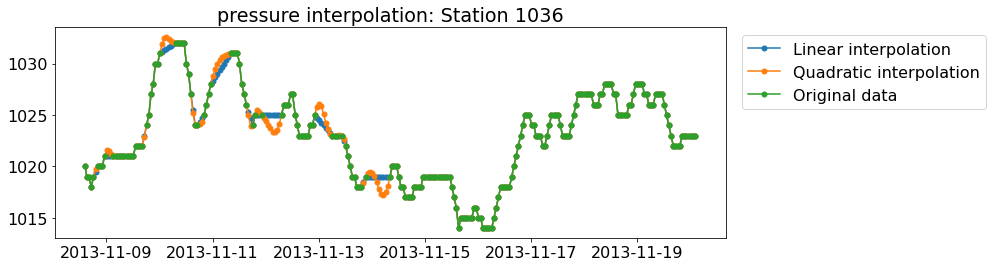

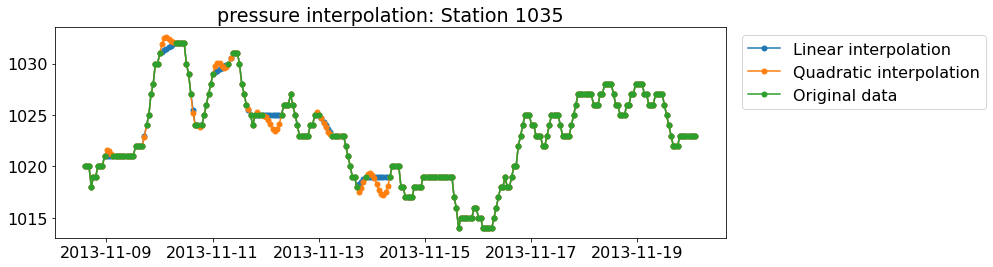

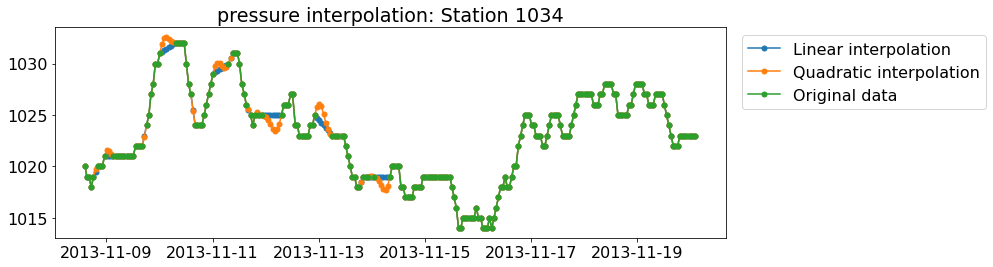

In [5]:
### Visualize interpolated data in worst case (most missing data)

sids = [1036, 1035, 1034]
var = 'pressure'
for sid in sids:
    plt.figure(figsize=(15,4))
    tmp_df = data_df[data_df.station_id==sid]
    plt.plot(tmp_df[var].interpolate('linear'), 'o-', label='Linear interpolation', markersize=5)
    plt.plot(tmp_df[var].interpolate('quadratic'), 'o-', label='Quadratic interpolation', markersize=5)
    plt.plot(tmp_df[var], 'o-', label='Original data', markersize=5)
    plt.title(var+' interpolation: Station '+str(sid))
    plt.legend(bbox_to_anchor=[1.4,1]);plt.tight_layout();

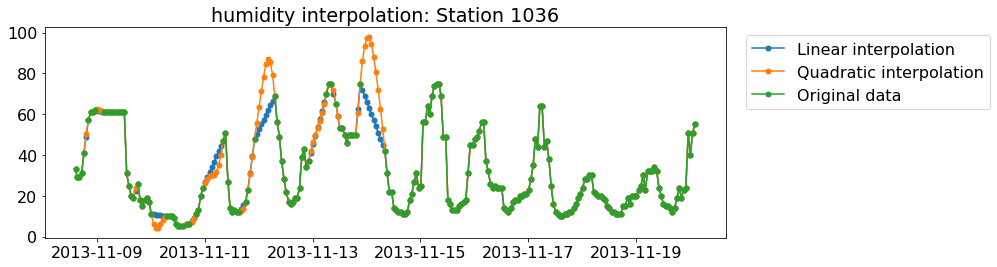

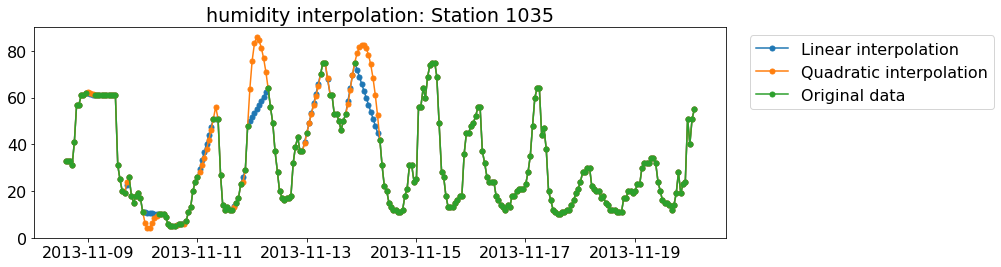

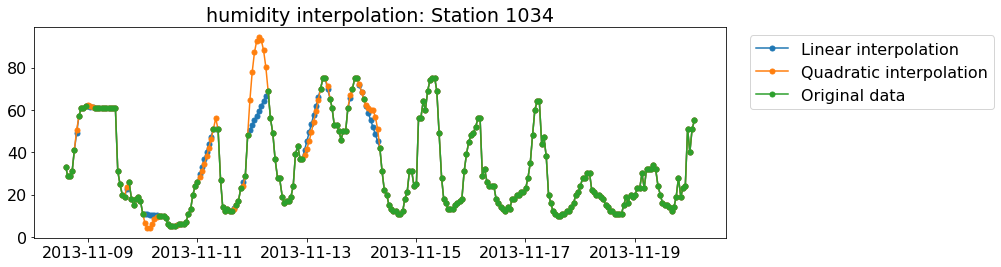

In [6]:
### Visualize interpolated data in worst case (most missing data)

sids = [1036, 1035, 1034]
var = 'humidity'
for sid in sids:
    plt.figure(figsize=(15,4))
    tmp_df = data_df[data_df.station_id==sid]
    plt.plot(tmp_df[var].interpolate('linear'), 'o-', label='Linear interpolation', markersize=5)
    plt.plot(tmp_df[var].interpolate('quadratic'), 'o-', label='Quadratic interpolation', markersize=5)
    plt.plot(tmp_df[var], 'o-', label='Original data', markersize=5)
    plt.title(var+' interpolation: Station '+str(sid))
    plt.legend(bbox_to_anchor=[1.4,1]);plt.tight_layout();

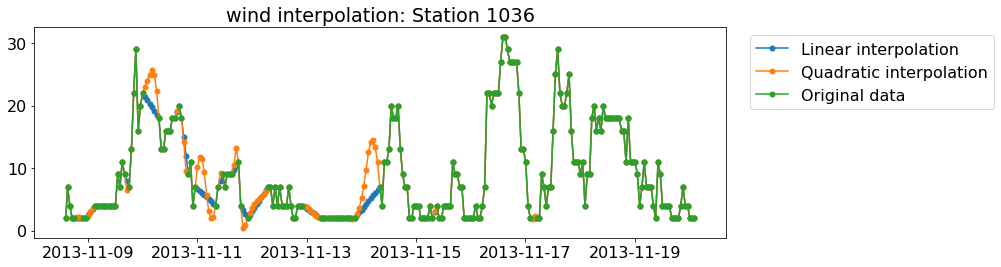

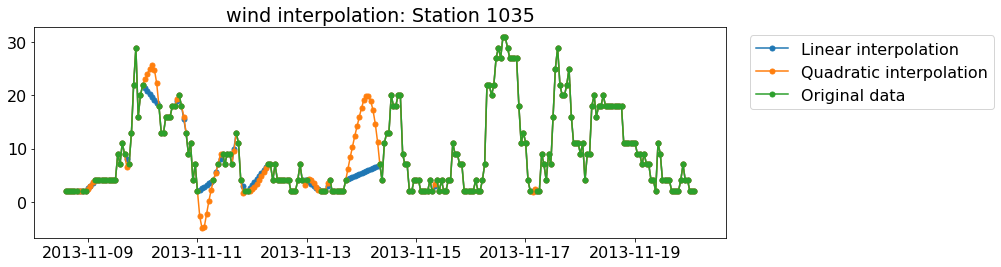

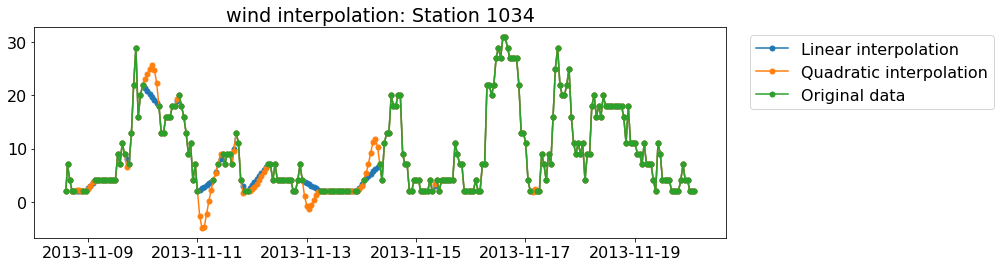

In [4]:
### Visualize interpolated data in worst case (most missing data)

sids = [1036, 1035, 1034]
var = 'wind'
for sid in sids:
    plt.figure(figsize=(15,4))
    tmp_df = data_df[data_df.station_id==sid]
    plt.plot(tmp_df[var].interpolate('linear'), 'o-', label='Linear interpolation', markersize=5)
    plt.plot(tmp_df[var].interpolate('quadratic'), 'o-', label='Quadratic interpolation', markersize=5)
    plt.plot(tmp_df[var], 'o-', label='Original data', markersize=5)
    plt.title(var+' interpolation: Station '+str(sid))
    plt.legend(bbox_to_anchor=[1.4,1]);plt.tight_layout();

### Fill with various interpolations

In [7]:
### Fill data
final_dfs = []
ipols = ['linear', 'quadratic']

for ipol in ipols:
    df_list = []
    for station in data_df.station_id.unique():
        tmp_df = data_df[data_df.station_id==station]
        tmp_df[['temperature','pressure','humidity','wind']] = tmp_df[['temperature','pressure','humidity','wind']].interpolate(ipol)
        tmp_df = tmp_df.interpolate('ffill').interpolate('bfill')
        df_list.append(tmp_df)
    
    final_df = pd.concat(df_list).sort_index()
    assert final_df.shape == final_df.dropna().shape # Checking presense of NA
    final_dfs.append(final_df)

linear_df, quadratic_df = final_dfs

# Generate train, test data

In [8]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import os
import sys

In [9]:
all_stations = linear_df.station_id.unique()
splitter = KFold(n_splits=6, random_state=42, shuffle=True)
names = ['linear/', 'quadratic/']
path = '../production/pm25_beijing_best36/'
Xcols = ['longitude', 'latitude', 'temperature', 'pressure', 'humidity', 'wind']
ycol = 'PM25_AQI_value'

pd.to_pickle(Xcols, path+'Xcols.pickle')
pd.to_pickle(ycol, path+'ycol.pickle')

init = time()
for df_i, df in enumerate([linear_df, quadratic_df]):
    for tv_i, (train_idx, test_idx) in enumerate(splitter.split(all_stations)):
        train_stations = all_stations[train_idx]
        test_stations = all_stations[test_idx]
        
        train_df = df[df.station_id.isin(train_stations)]
        test_df = df[df.station_id.isin(test_stations)]
        
        for end in ['/train/X/', '/train/y', '/test/X/', '/test/y', '/scaler/']:
                if not os.path.exists(path+names[df_i]+'data/fold_'+str(tv_i)+end):
                    os.makedirs(path+names[df_i]+'data/fold_'+str(tv_i)+end)
        
        pd.to_pickle(train_stations, path+names[df_i]+'data/fold_'+str(tv_i)+'/train_stations.pickle')
        pd.to_pickle(test_stations, path+names[df_i]+'data/fold_'+str(tv_i)+'/test_stations.pickle')
        
        for t_i, ts in enumerate(df.index.unique()):
            clear_output(True)
            xscaler = StandardScaler()
            yscaler = StandardScaler()
            
            train_x = xscaler.fit_transform(train_df.loc[ts][Xcols])
            test_x = xscaler.transform(test_df.loc[ts][Xcols])
            
            train_y = yscaler.fit_transform(train_df.loc[ts][[ycol]])
            test_y = test_df.loc[ts][[ycol]].values.reshape(-1,1)
            
            print(f'{df_i=} {tv_i=} {t_i=} len of train={train_x.shape}, len of test={test_x.shape}')
            
            np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/train/X/'+str(t_i).zfill(5)+'.npy', train_x)
            np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/test/X/'+str(t_i).zfill(5)+'.npy', test_x)
            
            np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/train/y/'+str(t_i).zfill(5)+'.npy', train_y)
            np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/test/y/'+str(t_i).zfill(5)+'.npy', test_y)
            
            pd.to_pickle(yscaler, path+names[df_i]+'data/fold_'+str(tv_i)+'/scaler/'+str(t_i).zfill(5)+'.pickle')
print('\nDataset ready in',(time()-init)/60,'minutes')

df_i=1 tv_i=5 t_i=276 len of train=(30, 6), len of test=(6, 6)

Dataset ready in 0.7146528800328572 minutes


# Generate train, test for ADAIN

In [10]:
all_stations = linear_df.station_id.unique()
splitter = KFold(n_splits=6, random_state=42, shuffle=True)
names = ['linear/', 'quadratic/']
path = '../production/pm25_beijing_best36/'
Xcols = ['longitude', 'latitude', 'temperature', 'pressure', 'humidity', 'wind']
met_cols = ['temperature', 'pressure', 'humidity', 'wind']
ycol = ['PM25_AQI_value']
ws = 24

init = time()
for df_i, df in enumerate([linear_df, quadratic_df]):
    for tv_i, (train_idx, test_idx) in enumerate(splitter.split(all_stations)):
        train_stations = all_stations[train_idx]
        test_stations = all_stations[test_idx]
        
        train_df = df[df.station_id.isin(train_stations)]
        test_df = df[df.station_id.isin(test_stations)]
        
        xscaler = StandardScaler()
        train_df[Xcols] = xscaler.fit_transform(train_df[Xcols])
        test_df[Xcols] = xscaler.transform(test_df[Xcols])
        
        yscaler = StandardScaler()
        train_df[ycol] = yscaler.fit_transform(train_df[ycol])
        
        for end in ['/train/adain', '/test/adain']:
            if not os.path.exists(path+names[df_i]+'data/fold_'+str(tv_i)+end):
                os.makedirs(path+names[df_i]+'data/fold_'+str(tv_i)+end)
        
        ## For training
        
        stn_dist_list = []
        stn_met_aq_list = []
        local_met_list = []
        local_aqi_list = []
        tst_stn_dist_list = []
        tst_stn_met_aq_list = []
        tst_local_met_list = []
        tst_local_aqi_list = []
        
        t_idx = df.index.unique()
        for t_i, ts in enumerate(t_idx[:-ws+1]):
            clear_output(True)
            
            print(f'{df_i=} {tv_i=} {t_i=}')
            
            f_ts = t_idx[t_i]
            l_ts = t_idx[t_i+ws-1]
            stn_df = train_df.loc[f_ts:l_ts][met_cols+ycol+['station_id']]
            tst_stn_df = test_df.loc[f_ts:l_ts][met_cols+ycol+['station_id']]
            ## For test
            tst_dist = np.nan*np.zeros((1,2,len(train_stations),len(test_stations)))
            tst_loc_met = np.nan*np.zeros((1,ws,len(met_cols),len(test_stations)))
            for tst_idx, test_station in enumerate(test_stations):
                local_loc = station_df.loc[test_station][['longitude','latitude']].values.reshape(-1,2)
                station_loc = station_df[station_df.index.isin(train_stations)][['longitude','latitude']].values
                tst_dist[0,:,:,tst_idx] = (station_loc-local_loc).T
                
                # Saving local met sample
                tst_loc_met[0,:,:,tst_idx] = tst_stn_df[tst_stn_df.station_id==test_station][met_cols].values
                
            # Saving dist samples
            tst_stn_dist_list.append(tst_dist)
            
            # Saving met_aq sample
            stn_met_aq = stn_df[stn_df.station_id.isin(train_stations)].drop(columns=['station_id'])
            ans = np.concatenate([i[:,:,None] for i in np.split(stn_met_aq.values, len(train_stations))], axis=2)
            tst_stn_met_aq_list.append(ans[None,:,:,:])
#             print(ans[None,:,:,:].shape)
            
            # Saving loc_met sample
            tst_local_met_list.append(tst_loc_met)
#             print(tst_loc_met.shape)
            
            # Saving aqi for loca
            tst_local_aqi_list.append(tst_stn_df.loc[l_ts][ycol].values.T)
            
            # For train
            for local_station in train_stations:
                tmp_stations = train_stations.copy().tolist()
                tmp_stations.remove(local_station)
                
                local_loc = station_df.loc[local_station][['longitude','latitude']].values.reshape(-1,2)
                station_loc = station_df[station_df.index.isin(tmp_stations)][['longitude','latitude']].values
                
                # Saving dist samples
                stn_dist_list.append((station_loc-local_loc).T[None,:,:])
                
                # Saving train_met_aq sample
                stn_met_aq = stn_df[stn_df.station_id.isin(tmp_stations)].drop(columns=['station_id'])
                ans = np.concatenate([i[:,:,None] for i in np.split(stn_met_aq.values, len(tmp_stations))], axis=2)
                stn_met_aq_list.append(ans[None,:,:,:])
                
                # Saving local_met sample
                local_met_list.append(stn_df[stn_df.station_id==local_station][met_cols].values[None,:,:])
                
                # Saving test aqi
                local_aqi_list.append(stn_df[stn_df.station_id==local_station].loc[l_ts][ycol].values)
                
#         print(np.concatenate(stn_dist_list).shape)
#         print(np.concatenate(stn_met_aq_list).shape)
#         print(np.concatenate(local_met_list).shape)
#         print(np.concatenate(local_aqi_list).shape)
#         sys.exit()
        np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/train/adain/trn_dst.npy', np.concatenate(stn_dist_list))
        np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/train/adain/trn_metaq.npy', np.concatenate(stn_met_aq_list))
        np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/train/adain/tst_met.npy', np.concatenate(local_met_list))
        np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/train/adain/tst_aqi.npy', np.concatenate(local_aqi_list))
        
        np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/test/adain/trn_dst.npy', np.concatenate(tst_stn_dist_list))
        np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/test/adain/trn_metaq.npy', np.concatenate(tst_stn_met_aq_list))
        np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/test/adain/tst_met.npy', np.concatenate(tst_local_met_list))
        np.save(path+names[df_i]+'data/fold_'+str(tv_i)+'/test/adain/tst_aqi.npy', np.concatenate(tst_local_aqi_list))
        
        if not os.path.exists(path+names[df_i]+'data/fold_'+str(tv_i)+'/scaler/adain/'):
            os.makedirs(path+names[df_i]+'data/fold_'+str(tv_i)+'/scaler/adain/')
        
        pd.to_pickle(yscaler, path+names[df_i]+'data/fold_'+str(tv_i)+'/scaler/adain/yscaler.pickle')
        
print('\nDataset ready in',(time()-init)/60,'minutes')

df_i=1 tv_i=5 t_i=253

Dataset ready in 7.3814565698305765 minutes
